In [123]:
import regex as re
import pandas as pd

# Merge Current & 2026 Population Dataset

In [124]:
population = pd.read_csv('../data/landing/new_population.csv')

# Combine first and second row to make the new column names
population.columns = [f"{col}_{str(population.iloc[0, idx])}" for idx, col in enumerate(population.columns)]

# Drop the first row since it's now part of the header
population = population.drop(0).reset_index(drop=True)

# Rename columns
new_cols = [
    "gccsa_code", "gcsa_name", "sa4_code", "sa4_name", "sa3_code", "sa3_name", 
    "sa2_code", "sa2_name", "erp_2001", "erp_2002", "erp_2003","erp_2004",
    "erp_2005","erp_2006","erp_2007","erp_2008","erp_2009","erp_2010",
    "erp_2011","erp_2012","erp_2013","erp_2014","erp_2015","erp_2016",
    "erp_2017","erp_2018","erp_2019", "erp_2020", "erp_2021", "erp_2022", 
    "erp_2023"
]

population.columns = new_cols

# Remove nan value for gccsa_code
population = population[~population['gccsa_code'].isna()]

# Only filter data in Victoria
population = population[population['gccsa_code'].str.contains('vic|mel', case=False)]

# Drop columns we don't need
drop_cols = ["gccsa_code", "gcsa_name", "sa4_code", "sa4_name", "sa3_code", "sa3_name"]
population = population.drop(columns=drop_cols)

# Lower suburb name
population['sa2_name'] = population['sa2_name'].str.lower()

In [125]:
future_pop = pd.read_csv('../data/landing/future_population.csv')

# Only categorize by SA2
future_pop = future_pop[future_pop['Region Type'] == 'SA2']

# Drop columns we don't need
future_drop = ['GCCSA', 'SA4 Code', 'SA3 Code', 'SA2  code', 'Region Type', '2021']
future_pop = future_pop.drop(columns=future_drop)

future_pop['Region'] = future_pop['Region'].str.lower()

new_future_cols = ['sa2_name', 'erp_2026', 'erp_2031', 'erp_2036']

future_pop.columns = new_future_cols

In [126]:
merged_population = pd.merge(population, future_pop, on='sa2_name')

In [127]:
# Define directional modifiers and the word 'surrounds' to be removed
directional_modifiers = [' - east', ' - west', ' - north', ' - south', ' - central', ' surrounds', ' (north)', ' (south)', ' (east)', ' (west)']
pattern = '|'.join([re.escape(suffix) for suffix in directional_modifiers])
merged_population['sa2_name'] = merged_population['sa2_name'].str.replace(pattern, '', regex=True)

# Split sa2_name where multiple names are separated by hyphens
merged_population['sa2_name'] = merged_population['sa2_name'].str.split(' - ')

# Explode the lists into separate rows
population_exploded = merged_population.explode('sa2_name')
population_exploded = population_exploded.reset_index(drop=True)

# Mapping for the SA2 names to the correct suburbs
sa2_name_mapping = {
    'ballarat' : 'ballarat central',
    'flemington racecourse' : 'flemington',
    'southbank wharf' : 'south wharf',
    'port melbourne industrial' : 'port melbourne',
    'reservoir east' : 'reservoir',
    'reservoir west' : 'reservoir',
    'research warrandyte' : 'warrandyte',
    'essendon airport' : 'essendon',
    'gladstone parkmeadows' : 'gladstone park',
    'craigieburn west' : 'craigieburn',
    'wandin' : 'wandin north',
    'pakenham east' : 'pakenham',
    'pakenham west' : 'pakenham',
    'narre warren west' : 'narre warren',
    'berwick east' : 'berwick',
    'berwick west' : 'berwick',
    'point cook east' : 'point cook',
    'point cook west' : 'point cook',
    'truganina east' : 'truganina',
    'truganina west' : 'truganina',
    'melbourne cbd' : 'melbourne'
}

# Remove the "(vic.)" from sa2_name values
population_exploded['sa2_name'] = population_exploded['sa2_name'].str.replace(r'\s*\(vic\.\)', '', regex=True)
population_exploded['sa2_name'] = population_exploded['sa2_name'].replace(sa2_name_mapping)

In [128]:
erp_cols = merged_population.columns[merged_population.columns.str.contains('erp')]
population_exploded[erp_cols] = population_exploded[erp_cols].astype('int')

# Create the aggregation dictionary
aggregation_functions = {col: 'sum' for col in erp_cols}

# Apply the groupby and aggregation
population_grouped = population_exploded.groupby('sa2_name').agg(aggregation_functions).reset_index()
population_grouped.to_csv('../data/curated/new_population.csv', index=False)

# Extrapolation

In [129]:
population = pd.read_csv('../data/curated/new_population.csv')

In [130]:
new_cols = ["sa2_name", "2001", "2002", "2003","2004","2005","2006","2007","2008",
            "2009","2010","2011","2012","2013","2014","2015","2016","2017","2018",
            "2019", "2020", "2021", "2022", "2023", "2026", "2031", "2036"]

population.columns = new_cols

In [132]:
population.columns

Index(['sa2_name', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2026', '2031',
       '2036'],
      dtype='object')

In [131]:
population

,sa2_name,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2017,2018,2019,2020,2021,2022,2023,2026,2031,2036
0,abbotsford,4150,4339,4444,4452,4498,4537,4638,4727,4833,...,9291,9527,9594,9672,9258,9513,10008,10834,11823,12872
1,aberfeldie,13659,13645,13650,13673,13776,13908,14043,14215,14416,...,16833,16935,16974,16920,16175,16185,16628,17197,18166,19155
2,airport west,6997,6970,6952,6904,6870,6878,6920,6983,7067,...,8019,8169,8390,8362,8240,8295,8464,8845,9525,10142
3,albert park,12368,12595,12800,12997,13269,13550,13731,13928,14245,...,16500,16728,17081,16955,16011,16177,16861,17038,17962,18638
4,albion,6640,6597,6560,6523,6523,6556,6559,6758,7087,...,8229,8228,8183,8082,7590,7480,7711,8346,9125,9870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,yarraville,12573,12549,12686,12854,13006,13205,13536,13815,14030,...,15804,15991,16092,16068,15651,15661,16020,16695,17492,18451
512,yarrawonga,5484,5459,5603,5749,5971,6291,6491,6651,6831,...,8172,8297,8418,8508,8593,8727,8812,9271,10011,10719
513,yarriambiack,8114,8023,7918,7780,7654,7552,7450,7378,7352,...,6648,6639,6617,6583,6453,6376,6327,6238,6060,5881
514,yea,3497,3547,3563,3552,3540,3573,3563,3537,3477,...,3698,3803,3907,4019,4142,4257,4297,4508,4776,5015


In [112]:
population['sa2_name'].unique()

array(['abbotsford', 'aberfeldie', 'airport west', 'albert park',
       'albion', 'alexandra', 'alfredton', 'alphington', 'alps', 'altona',
       'altona meadows', 'altona north', 'anglesea', 'ararat', 'ardeer',
       'armadale', 'armstrong creek', 'ascot', 'ascot vale', 'ashburton',
       'ashwood', 'aspendale', 'aspendale gardens', 'avoca',
       'avondale heights', 'bacchus marsh', 'bairnsdale',
       'ballarat central', 'ballarat east', 'ballarat north', 'balwyn',
       'balwyn north', 'bannockburn', 'baranduda', 'barwon heads',
       'bayswater', 'bayswater north', 'beaconsfield', 'beaufort',
       'beaumaris', 'beechworth', 'belgrave', 'bell park', 'belmont',
       'benalla', 'bendigo', 'bentleigh', 'bentleigh east', 'berwick',
       'black rock', 'blackburn', 'blackburn south', 'bonbeach',
       'boronia', 'box hill', 'box hill north', 'braeside', 'braybrook',
       'briar hill', 'bright', 'brighton', 'brighton east', 'broadford',
       'broadmeadows', 'brookfield'

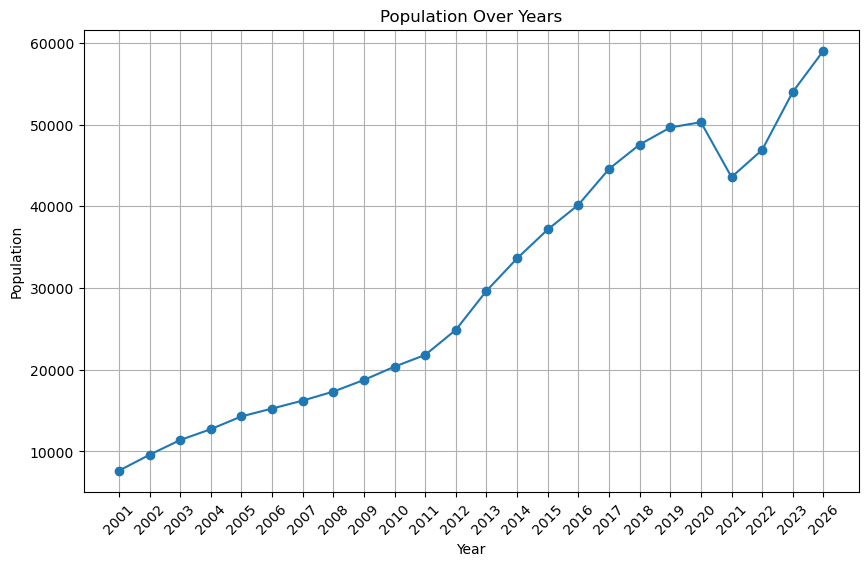

In [120]:
import matplotlib.pyplot as plt

# Assuming 'population' is your DataFrame

# Step 1: Select the row you want to plot
# You can use .loc[] if you know the index or the name
row_to_plot = population.loc[population['sa2_name'] == 'melbourne']

# If you want to use an index, e.g., the first row:
# row_to_plot = population.iloc[0]

# Step 2: Prepare the data for plotting
# Convert the row to a Series, dropping the 'sa2_name' column
data_to_plot = row_to_plot.iloc[0, 1:]  # Drop the first column ('sa2_name')

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data_to_plot.index, data_to_plot.values, marker='o')  # Using a line plot with markers
plt.title('Population Over Years')
plt.xlabel('Year')
plt.ylabel('Population')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.grid()
plt.show()

In [101]:
current_population = population.drop('2026', axis = 1)

In [102]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Assuming 'population' is your DataFrame

# Step 1: Prepare the data
# Reshape the DataFrame to have a single feature column (year) and target column (population)
years = np.array([int(year) for year in current_population.columns[1:]]).reshape(-1, 1)  # Years from 2001 to 2026
populations = current_population.iloc[:, 1:].values  # Population data

# Step 2: Fit a linear regression model for each 'sa2_name'
predictions = []
for i in range(len(populations)):
    model = LinearRegression()
    model.fit(years, populations[i])  # Fit model for the current SA2
    # Predict for 2024, 2025, and 2027
    pred_2024 = model.predict(np.array([[2024]]))[0]
    pred_2025 = model.predict(np.array([[2025]]))[0]
    pred_2026 = model.predict(np.array([[2026]]))[0]
    pred_2027 = model.predict(np.array([[2027]]))[0]
    predictions.append([pred_2024, pred_2025, pred_2026, pred_2027])

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, columns=['2024', '2025', '2026', '2027'])

# Step 3: Concatenate predictions to the original DataFrame
population = pd.concat([population, predictions_df], axis=1)

# Display the updated DataFrame with predictions
population[['sa2_name', '2023', '2024', '2025', '2026', '2027']].head()


,sa2_name,2023,2024,2025,2026,2026,2027
0,abbotsford,10008,10518.296443,10836.614625,10834,11154.932806,11473.250988
1,aberfeldie,16628,17339.470356,17516.408103,17197,17693.345850,17870.283597
2,airport west,8464,8492.003953,8573.953557,8845,8655.903162,8737.852767
3,albert park,16861,17603.063241,17823.756917,17038,18044.450593,18265.144269
4,albion,7711,8323.782609,8404.652174,8346,8485.521739,8566.391304


In [103]:
population['2026']

,2026,2026
0,10834,11154.932806
1,17197,17693.345850
2,8845,8655.903162
3,17038,18044.450593
4,8346,8485.521739
...,...,...
511,16695,17051.928854
512,9271,9542.930830
513,6238,5992.371542
514,4508,4085.606719


In [89]:
populations

array([[ 4150,  4339,  4444, ...,  9513, 10008, 10834],
       [13659, 13645, 13650, ..., 16185, 16628, 17197],
       [ 6997,  6970,  6952, ...,  8295,  8464,  8845],
       ...,
       [ 8114,  8023,  7918, ...,  6376,  6327,  6238],
       [ 3497,  3547,  3563, ...,  4257,  4297,  4508],
       [  873,   916,   988, ..., 28568, 31976, 37788]])

In [106]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Assuming 'population' is your DataFrame

# Step 1: Prepare the data
# Reshape the DataFrame to have a single feature column (year) and target column (population)
years = np.array([int(year) for year in population.columns[1:]]).reshape(-1, 1)  # Years from 2001 to 2026
populations = population.iloc[:, 1:].values  # Population data

# Step 2: Fit a linear regression model for each 'sa2_name'
predictions = []
for i in range(len(populations)):
    model = LinearRegression()
    model.fit(years, populations[i])  # Fit model for the current SA2
    # Predict for 2024, 2025, and 2027
    pred_2024 = model.predict(np.array([[2024]]))[0]
    pred_2025 = model.predict(np.array([[2025]]))[0]
    pred_2027 = model.predict(np.array([[2027]]))[0]  # Predicting for 2027
    predictions.append([pred_2024, pred_2025, pred_2027])

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, columns=['2024', '2025', '2027'])

# Step 3: Concatenate predictions to the original DataFrame
population = pd.concat([population, predictions_df], axis=1)

# Display the updated DataFrame with predictions
print(population[['sa2_name', '2023', '2024', '2025', '2026', '2027']].head())


       sa2_name   2023          2024          2025   2026          2027
0    abbotsford  10008  10463.953188  10778.682664  10834  11408.141617
1    aberfeldie  16628  17255.424573  17426.812127  17197  17769.587234
2  airport west   8464   8524.023545   8608.087651   8845   8776.215863
3   albert park  16861  17432.641895  17642.081331  17038  18060.960203
4        albion   7711   8300.157522   8379.466940   8346   8538.085776


In [107]:
population

,sa2_name,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2018,2019,2020,2021,2022,2023,2026,2024,2025,2027
0,abbotsford,4150,4339,4444,4452,4498,4537,4638,4727,4833,...,9527,9594,9672,9258,9513,10008,10834,10463.953188,10778.682664,11408.141617
1,aberfeldie,13659,13645,13650,13673,13776,13908,14043,14215,14416,...,16935,16974,16920,16175,16185,16628,17197,17255.424573,17426.812127,17769.587234
2,airport west,6997,6970,6952,6904,6870,6878,6920,6983,7067,...,8169,8390,8362,8240,8295,8464,8845,8524.023545,8608.087651,8776.215863
3,albert park,12368,12595,12800,12997,13269,13550,13731,13928,14245,...,16728,17081,16955,16011,16177,16861,17038,17432.641895,17642.081331,18060.960203
4,albion,6640,6597,6560,6523,6523,6556,6559,6758,7087,...,8228,8183,8082,7590,7480,7711,8346,8300.157522,8379.466940,8538.085776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,yarraville,12573,12549,12686,12854,13006,13205,13536,13815,14030,...,15991,16092,16068,15651,15661,16020,16695,16626.668287,16805.088137,17161.927837
512,yarrawonga,5484,5459,5603,5749,5971,6291,6491,6651,6831,...,8297,8418,8508,8593,8727,8812,9271,9168.416655,9329.610085,9651.996944
513,yarriambiack,8114,8023,7918,7780,7654,7552,7450,7378,7352,...,6639,6617,6583,6453,6376,6327,6238,6194.034727,6116.745798,5962.167940
514,yea,3497,3547,3563,3552,3540,3573,3563,3537,3477,...,3803,3907,4019,4142,4257,4297,4508,4097.689471,4132.133074,4201.020281


In [79]:
# Step 1: Initialize columns 2024 and 2025 with NaN values as float type
population['2024'] = pd.NA
population['2025'] = pd.NA

# Step 2: Ensure that all columns are numeric before interpolation
year_columns = population.columns[population.columns.str.match(r'\d{4}')]

# Convert these year columns to numeric
population[year_columns] = population[year_columns].apply(pd.to_numeric, errors='coerce')

# Step 3: Perform linear interpolation along each row (axis=1) to fill in 2024 and 2025 values
population = population.interpolate(method='linear', axis=1)

# Step 4: Convert the interpolated columns back to integers if needed
population[year_columns] = population[year_columns].astype('Int64')

# Display the DataFrame with interpolated values
population[['sa2_name', '2023', '2024', '2025', '2026']].head()


TypeError: Cannot interpolate with all object-dtype columns in the DataFrame. Try setting at least one column to a numeric dtype.

In [74]:
years = population.drop('sa2_name', axis = 1)

In [76]:
years

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2017,2018,2019,2020,2021,2022,2023,2026,2024,2025
0,4150,4339,4444,4452,4498,4537,4638,4727,4833,5029,...,9291,9527,9594,9672,9258,9513,10008,10834,NaN,NaN
1,13659,13645,13650,13673,13776,13908,14043,14215,14416,14617,...,16833,16935,16974,16920,16175,16185,16628,17197,NaN,NaN
2,6997,6970,6952,6904,6870,6878,6920,6983,7067,7175,...,8019,8169,8390,8362,8240,8295,8464,8845,NaN,NaN
3,12368,12595,12800,12997,13269,13550,13731,13928,14245,14595,...,16500,16728,17081,16955,16011,16177,16861,17038,NaN,NaN
4,6640,6597,6560,6523,6523,6556,6559,6758,7087,7334,...,8229,8228,8183,8082,7590,7480,7711,8346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,12573,12549,12686,12854,13006,13205,13536,13815,14030,14185,...,15804,15991,16092,16068,15651,15661,16020,16695,NaN,NaN
512,5484,5459,5603,5749,5971,6291,6491,6651,6831,6981,...,8172,8297,8418,8508,8593,8727,8812,9271,NaN,NaN
513,8114,8023,7918,7780,7654,7552,7450,7378,7352,7248,...,6648,6639,6617,6583,6453,6376,6327,6238,NaN,NaN
514,3497,3547,3563,3552,3540,3573,3563,3537,3477,3428,...,3698,3803,3907,4019,4142,4257,4297,4508,NaN,NaN


In [77]:
years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   2001    516 non-null    int64 
 1   2002    516 non-null    int64 
 2   2003    516 non-null    int64 
 3   2004    516 non-null    int64 
 4   2005    516 non-null    int64 
 5   2006    516 non-null    int64 
 6   2007    516 non-null    int64 
 7   2008    516 non-null    int64 
 8   2009    516 non-null    int64 
 9   2010    516 non-null    int64 
 10  2011    516 non-null    int64 
 11  2012    516 non-null    int64 
 12  2013    516 non-null    int64 
 13  2014    516 non-null    int64 
 14  2015    516 non-null    int64 
 15  2016    516 non-null    int64 
 16  2017    516 non-null    int64 
 17  2018    516 non-null    int64 
 18  2019    516 non-null    int64 
 19  2020    516 non-null    int64 
 20  2021    516 non-null    int64 
 21  2022    516 non-null    int64 
 22  2023    516 non-null    in

In [75]:
# Impute 2024 and 2025, then predict 2027

years['2024'] = pd.NA
years['2025'] = pd.NA

years = years.interpolate(method='linear', axis=1)

# Display the DataFrame with the imputed values for 2024 and 2025
years[['sa2_name', '2023', '2024', '2025', '2026']].head()

TypeError: Cannot interpolate with all object-dtype columns in the DataFrame. Try setting at least one column to a numeric dtype.

In [2]:
from sklearn.linear_model import LinearRegression
import numpy as np

# List of future years you want to predict
future_years = np.array([[2024], [2025], [2027]])

# Initialize an empty list to store the predictions
predictions_list = []

# Group by 'suburb' and 'offence_division'
for (suburb, offence_division), group in df.groupby(['suburb', 'offence_division']):
    
    # Prepare the data
    X = group[['year']]
    y = group['total_offence_count']
    
    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict for future years
    predictions = model.predict(future_years)
    
    # Store the results with labels 'suburb', 'year', 'offence_division'
    for year, pred in zip(future_years.flatten(), predictions):
        predictions_list.append({
            'suburb': suburb,
            'year': year,
            'offence_division': offence_division,
            'predicted_total_offence_count': pred
        })

# Convert the predictions to a DataFrame with the desired labels
predictions_df = pd.DataFrame(predictions_list)

# Display the predictions
print(predictions_df)

In [6]:
future_pop.columns

Index(['GCCSA', 'SA4 Code', 'SA3 Code', 'SA2  code', 'Region Type', 'Region',
       '2021', '2026', '2031', '2036'],
      dtype='object')